<a href="https://colab.research.google.com/github/10o0o/hands_on_machine_learning/blob/master/%ED%95%B8%EC%A6%88%EC%98%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_3%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 3. 분류
주어진 데이터들을 특정 범수(category)나 클래스(class)로 나누는 머신러닝 작업
지도학습의 한 유형으로, 데이터의 입력(feature), 정답(label)이 주어진 상태에서 학습하여 새로운 데이터에 대해 올바른 클래스를 예측하는 모델을 만드는 과정

- 목적
  - 데이터에 존재하는 패턴 학습 >> 입력 데이터를 사전에 정의된 범주 중 하나로 자동으로 분류
  - 새로운 데이터가 주어졌을 때 올바른 클래스를 예측하거나 판단


## 3.1 MNIST

- 7천개의 작은 이미지를 뜻한 (머신러닝 계의 Hello World)

다음은 OpenML.org에서 해당 데이터셋을 내려받는 *코드이다*

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

sklearn.datasets 패키지에 있는 함수는 대부분 3종류로 다음과 같다
- fetch_*: fetch_openml()과 같이 실전 데이터셋을 다운로드 하기 위한 함수
- load_*: 사이킷런에 번들로 포함된 소규모 데이터셋을 로드하기 위한 함수 (인터넷으로 다운로드 X)
- make_*: 테스트에 유용한 가짜 데이터 셋을 생성하기 위한 함수

생성된 데이터셋은 일반적으로 NumPy 배열이고, 입력(X), 와 타깃 데이터(y)를 담은 (X, y) 튜플로 반환된다.

sklearn.utils.Bunch 객체로 반환되는 데이터셋도 존재한다.
이 객체의 속성으로 다음과 같은 항목 참조가 가능하다
- DESCR: 데이터셋 설명
- data: 입력 데이터(2D, NumPy)
- target: 레이블, (1D, NumPy)


### fetch_openml()

입력을 판다스 데이터프레임, 레이블 >> 판다스 시리즈로 반환(데이터셋이 희소하지 않을 경우)

해당 쳅터 예제에서 사용할 MNIST 데이터셋은 이미지이므로 데이터프레임이 잘 맞지 않는다.
따라서 as_frame=False로 지정하여 넘파이 배열로 데이터를 받는다

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

# 모든 표현식의 결과를 출력하도록 설정
InteractiveShell.ast_node_interactivity = "all"

X, y = mnist.data, mnist.target

X
X.shape
y
y.shape

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

(70000, 784)

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

(70000,)

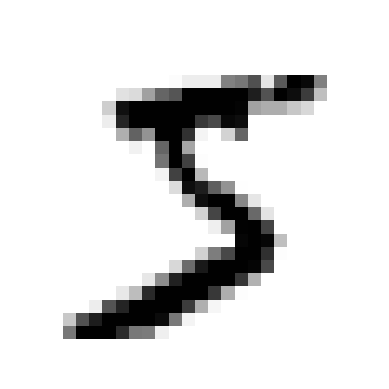

5


In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  # print(image_data)
  plt.imshow(image, cmap='binary') # 0을 흰색, 255를 검은색으로 나타내는 흑백 컬러맵
  plt.axis('off')

some_digit = X[0];
plot_digit(some_digit)
plt.show()

print(y[0])

## 3.2 이진 분류기 훈련

위의 예제에서 문제를 단순화 해서 하나의 숫자 5만 식별해보자
앞으로 만들 "5 감지기"는 5와 5가 아닌 숫자, 즉 2개의 클래스를 구분할 수 있는 이진 분류기(binary classifier)이다.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # 확률적 경사 하강법 분류기
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

SGDClassifier(random_state=42)

array([ True])

확률적 경사 하강법이란?

> 경사 하강법의 한 변형으로, 매번 손실 함수의 전체 데이터셋이 아닌, 랜덤하게 선택된 하나의 데이터 포인트(또는 소규모 배치)만을 이용해 기울기를 계산하고, 가중치를 업데이트 하는 방법


## 3.3 성능 측정

위 예제에서, 5-분류기가 잘 작동하는 것을 확인했다.
해당 분류기의 성능을 측정 하는 방식으로 다음과 같은 방식들이 있다

### 3.3.1 교차 검증을 사용한 정확도 측정
폴드가 3개인 k-폴드 교차 검즈응ㄹ 사용해 SGDClassifier 모델을 평가
* k-폴드 교차 검증은 훈련 세트를 k개(해당 예시에서는 3개)의 폴드로 나누고, 평가를 위해 매번 다른 폴드를 떼어놓고 모델을 k번 훈련하는것을 말한다

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

> 교차 검증 구현
>
> 다음 코드는 사이킷런의 cross_var_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력하는 함수이다



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))


SGDClassifier(random_state=42)

0.95035


SGDClassifier(random_state=42)

0.96035


SGDClassifier(random_state=42)

0.9604


아래는 모든 이미지를 가장 많이 등장하는 클래스로 분류하는 더미 분류기를 만들어서 비교하는 예제이다

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

# 정확도 추측
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

DummyClassifier()

False


array([0.90965, 0.90965, 0.90965])

위 예제에서 이미지의 10% 정도의 숫자만 5이기 때문에, 무조건 5가 아니라고 예측한다면 확률이 90%가 나온다.

즉 위 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다.
특히, 불균형한 데이터셋을 다룰 때 더욱 그렇다.

분류기의 성능을 평가하는 더 좋은 방법은 아래에 설명할 오차행렬을 조사하는 것이다.

### 3.3.2 오차행렬

모든 A/B 쌍에 대해 클래스A의 샘플이 클래스B로 분류된 횟수를 세는 것

실제 타깃과 비교할 수 있도록 예측값을 만들어야 한다.
테스트 세트로 예측을 만들 수 있지만, 여기서 사용하면 안된다.
> 테스트 세트는 프로젝트의 맨 마지막에 분류기가 출시 준비를 마치고 나서 사용
대신 cross_val_predict() 함수를 사용할 수 있다

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

오차행렬의 행은 실제 클래스를 나타내고, 열은 예측한 클래스를 나타낸다
위 코드의 결과는 55892개를 '5가 아님'으로 저오학하게 분류했고 (진짜 음성) 나머지 687개는 '5'라고 잘못 분류했다 (거짓 양성)

두번째 행에서 '5'이미지(양성 클래스)에 대한 것으로 1891개를 '5 아님'으로 잘못 분류했고 나머지 3530개를 정확히 '5'라고 분류했다 (진짜 양성)

아래 코드는 완벽한 분류기의 예시이다. (오차 행렬의 주대각선만 0이 아닌 값)

In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

오차 행렬이 많은 정보를 제공하지만, 가끔 더 요약된 지표가 필요할 때가 있다.

이 때, 양성 예측의 정확도 즉 분류기의 정밀도를 쓸 수 있다.

$$\text{정밀도} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$


TP는 진짜 양성의 수이고 FP는 거짓 양성의 수이다

정밀도는 재현율이라는 또 다른 지표와 같이 사용하는 것이 일반적이다

재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 민감도 또는 진짜 양성 비율(TPR)이라고 한다

$$\text{재현율} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

FN는 거짓 음성의 수 이다





### 3.3.3 정밀도와 재현율

사이킷런은 정밀도와 재현율을 포함한 분류기의 지표를 계산하는 여러 함수를 제공한다

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

0.8370879772350012

0.6511713705958311

이 때, 정밀도와 재현율을 F점수라고 하는 하나의 숫자로 만들 수 있다.

F점수는 정밀도와 재현율의 조화 평균이다.

> F점수의 일반화된 조화 평균식은 다음과 같다
>
> $$F_\beta = \left(1 + \beta^2\right) \cdot \frac{\text{정밀도} \cdot \text{재현율}}{\beta^2 \cdot \text{정밀도} + \text{재현율}}$$

결과적으로 분류기의 F점수가 높아지려면, 재현율과 정밀도 모두 높아야 한다.


$$
F_1 = \frac{2}{\frac{1}{\text{정밀도}} + \frac{1}{\text{재현율}}}
= \frac{2 \cdot (\text{정밀도} \cdot \text{재현율})}{\text{정밀도} + \text{재현율}}
= \frac{\text{TP}}{\text{TP} + \frac{\text{FN} + \text{FP}}{2}}
$$

$$F_1$$ 점수를 계산하려면 f1_score()를 호출하면 된다




In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높지만, 이게 항상 바람직하진 않다

상황에 따라 정밀도가 중요할 수 있고, 재현율이 중요할 수 있다.

예를 들어, 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정해보자

재현율은 높은데, 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 동영상만 노출시키는(높은 정밀도) 분류기를 선호할 것이다.

다른 예로, 감시 카메라를 통해 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정해보면,

분류기의 재현율이 99%라면, 정밀도가 30%만 되더라도 개노찮을 것이다.

정밀도와 재현율을 서로 반비례 관계에 있으며, 보통 이를 정밀도/재현율 트레이드오프 라고 한다

### 3.3.4 정밀도 / 재현율 트레이드 오프

SGDClassifier, 이 분류기는 결정 함수를 사용하여 각 샘플의 점수를 계산한다.

점수가 임곗값보다 크면, 샘플을 양성 클래스에 할당하고, 그렇지 않다면 음성 클래스에 할당한다

예를 들어 다음과 같은 샘플이 있다고 하자

8, 7, 3, 9, 5, 2, 5, 5, 6, 5, 5, 5

이 때 결정 임곗값이 가운데 두개이ㅡ 5 숫자 사이라고 가정해보자. 임곗값 오른쪽에 4개의 진짜 양성(숫자 5)과 하나의 거짓 양성(숫자 6)이 있다. 그렇기 때문에 이 임곘값에서 정밀도는 80%(4 / 5)이다. 하지만 실제 숫자 5는 6개고 분류기는 4개만 감지했으므로 재현율은 67%이다.

만약 임곗값을 높이면, 거짓 양성(숫자 6)이 진짜 음성이 되어 정밀도가 높아진다. 하지만 진짜 양성 하나가 거짓 음성이 되었으므로, 재현율이 50%로 줄어든다.

사이킷런에서 임곗값을 직접 지정할수는 없지만, 예측에 사용한 점수는 확인 가능하다.

분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([2164.22030239])

array([ True])

위 코드에서는 SGDClassifier 의 임곗값이 0이므로, predict() 메서드와 같은 결과(True)를 반환한다.

임곗값을 높여보자

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

위 코드는 임곗값을 높이면 재현율이 줄어든 다는 단편적인 예이다.

이미지가 실제 숫자 5이고 임곗값이 0일때는 분류기가 이를 감지했지만, 임곗값은 3000으로 높이면 이를 놓치게 된다

적절한 임곗값은 어떻게 정하나?

cross_val_predict를 사용해 훈련 세트의 모든 샘플의 점수를 구해야 한다.

이 때, 예측 결과가 아니라 결정 점수를 반환하도록 지정해야 한다.


In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

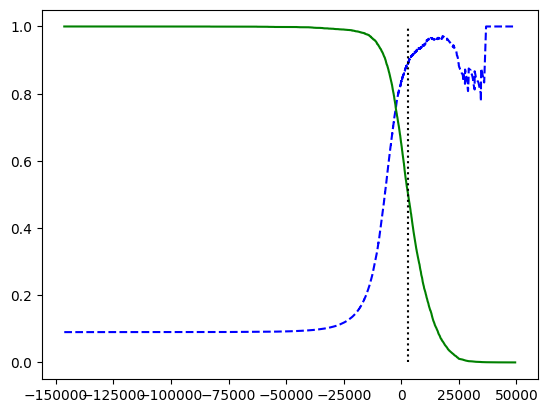

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="임곗값")
plt.show()

위 임곗값에서 정밀도는 약 90%이고, 재현율은 50%이다.

좋은 정밀도/재현율 트레이드 오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.



In [3]:
plt.plot(recalls, precisions, linewidth=2, label="정밀도/재현율 곡선")
plt.show()

NameError: name 'plt' is not defined

만약 정밀도 90% 달성이 목표라고 가정한다면, 그래프에서 사용할 임곗값을 찾을 수 있지만 정확하지 않다.

다른 방법은 정밀도가 최소 90%가 되면서, 가장 낮은 임곗값을 찾는것이다.

이를 위해 NumPy 배열의 argmax() 메서드를 사용할 수 있다.

In [ ]:
idx_for_90_precision = (precisions >= 0.090).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

-146348.56726173862

훈련 세트에 대한 예측을 만드려면 분류기의 predict() 메서드를 호출하는 대신 다음의 코드를 실행한다

In [ ]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

precision_score(y_train_5, y_train_pred_90)
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.09035

1.0

정밀도 90%를 달성한 분류기를 만들었다.

그러나, 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다. (48%)



### 3.3.5 ROC 곡선

수신기 조작 특성(ROC)곡선도 이진 분류에서 널리 사용되는 도구이다.

정밀도 / 재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아니라 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율의 다른 이름)의 곡선이다.

FPR은 양성으로 잘못 분류된 음성 샘플의 비율이다.
이는 1 - TNR 값이며, TNR은 진짜 음성 비율을 의미한다.
(TNR을 특이도라고 부르기도 한다.)

그러므로 ROC곡선은 민감도(재현율)에 대한 1-특이도 그래프이다.

> FPR과 TNR의 관계
>
> $$
> \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
> $$

> $$
> \text{TNR} = \frac{\text{TN}}{\text{FP} + \text{TN}}
> $$

> $$
> \text{FPR} + \text{TNR} = 1
> $$

> $$
> \text{FPR} = 1 - \text{TNR}
> $$

> $$
> \text{TNR} = 1 - \text{FPR}
> $$

ROC 곡선을 그리려면 먼저 roc_curve() 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야 한다


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

이 후, 멧플롯립을 사용해 TPR에 대한 FPR 곡선을 나타낼 수있다.

<Figure size 600x500 with 0 Axes>

Text(0.12, 0.71, 'Higher\nthreshold')

Text(0.5, 0, 'False Positive Rate (Fall-Out)')

Text(0, 0.5, 'True Positive Rate (Recall)')

(0.0, 1.0, 0.0, 1.0)

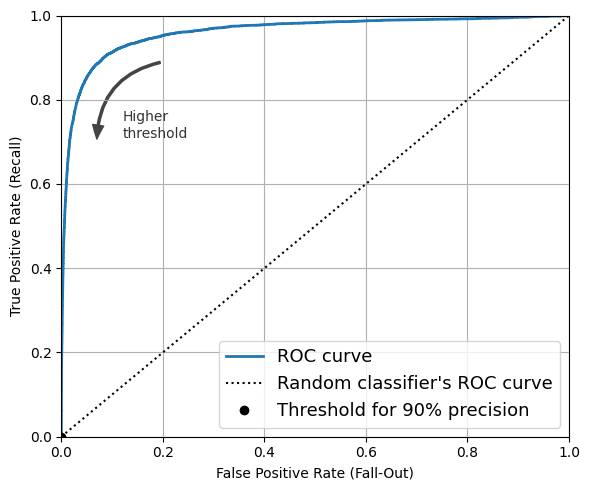

In [ ]:
import matplotlib.patches as patches

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # 추가 코드
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

여기에도 마찬가지로 트레이드오프가 있는데, TPR이 높을수록 분류기가 만드는 FPR이 늘어난다.

점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻하며, 좋은 분류기는 이점선에서 최대한 멀리 떨어져 있어야 한다. (왼쪽 위 모서리)


곡선 아래의 면적(AUC)를 측정해 분류기들을 비교할 수 있다.

완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다.

사이킷런은 ROC의 AUC를 계산하는 함수를 제공한다

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

아래는 RandomForestClassifier를 만들어 SGDClassifier의 PR곡선과 F1 점수를 비교하는 코드이다

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

precision_recall_curve() 함수는 각 샘플에 대한 레이브로가 점수를 기대한다.

따라서 랜덤 포레스트 분류기를 훈련하여 각 샘플에 점수를 부여해야 한다.

하지만, RandomForestClassifier는 작동 방식 때문에 decision_function()을 제공하지 않는다.

대신, 각 샘플에 대한 클래스 확률을 바노한하는 predict_proba()메서드를 제공한다.

In [ ]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [ ]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

이 모델은 첫 번째 이미지를 89%확률로 양성이라고 예측한다. 그리고 2번재 이미지를 99% 확률로 음성이라 예측한다

모든 이미지는 양성 또는 음성 둘 중 하나이기 때문에 각 행의 확률을 더하면 100%가 된다

<Figure size 600x500 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.0, 0.0, 1.0)

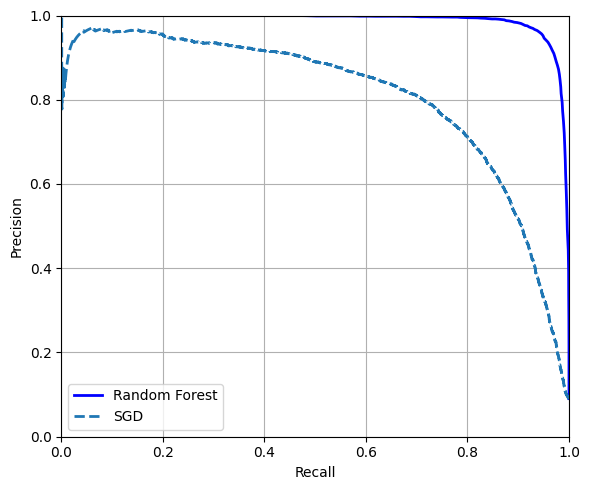

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(6, 5))
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

그래프에서 볼 수 있듯이, RandomForestClassifier의 PR 곡선이 SGDClassifier의 곡선보다 훨씬 더 좋아 보인다. (오른쪽 위 모서리에 더 가까움)

F1 점수와 FOC, AUC 점수도 훨씬 더 우수하다

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # 양성 확률 ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## 3.4 다중 분류

이진 분류기가 2개의 클래스를 구별하는 반면, 다중 분류기는 둘 이상의 클래스를 구분할 수 있다.

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이키설닝 알고리즘에 따라 자동으로 OvR또는 OvO를 실행한다.

아래는 sklearn.svm.SVC 클래스를 사용해 서포트 백터 머신 분류기를 테스트 하는 코드이다.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

위 코드는 5를 구별한 타깃 클래스(y_train_5) 대신 0~9의 원래 타깃 클래스(y_train)을 사용해 svc를 훈련시킨다.

10개의 클래스가 있기 때문에 사이킷런은 OvO 전략을 사용해 45개의 이진 분류기를 훈련한다.

아래는 한 이미지에 대한 예측을 만드는 코드이다

In [ ]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

위 코드는 실제로 클래스 쌍마다 하나씩 45번의 예측을 수행하여 가장 많은 쌍에서 승리한 클래스를 선택한다

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

분류기가 훈련될 때, 타깃 클래스의 리스트를 값으로 정렬하여 저장한다.

MNIST의 경우 classes_ 배열의 각 클래스의 인덱스가 클래스 값 자체와 같다

하지만 일반적으로 이런 경우는 드물어서 다음과 같이 클래스 레이블을 확인해야한다.

In [ ]:
svm_clf.classes_
svm_clf.classes_[5]

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

'5'

사이킷런에서 OvO, OvR을 사용하도록 강제하려면 OneVsOneClassifier 혹은 OneVsRestClassifier을 사용한다

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

OneVsRestClassifier(estimator=SVC(random_state=42))

array(['5'], dtype='<U1')

10

다중 분류 데이터셋에서 SGDClassifier를 훈련하고 예측을 만드는 것도 간단하다

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

SGDClassifier(random_state=42)

array(['3'], dtype='<U1')

위 코드에서 예측이 틀렸다. 이처럼 예측 오류가 발생할 수 있다.

아래 코드에서는 사이킷런이 OvR 전략을 사용했다.

10개의 클래스가 있기 때문에 10개의 이진 분류기를 훈련한다

decision_function() 메서드는 클래스마다 하나의 값을 반환한다.

In [ ]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

위 분류기는 예측 결과에 대한 강한 확신을 보익 욌다. (클래스 3의 점수는 +1824, 5의 점수는 -1386 나머지 점수는 큰 음수)

cross_val_score()함수를 이용해 평가하면 다음과 같다

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 85.8 이상을 얻었다.

랜덤 분류기를 사용했다면 10% 정확도를 얻었을 것이므로 점수가 아주 나쁘지는 않지만, 성능을 더 높일 여지가 있다. 다음과 같이 조정하면 89.1% 이상으로 높일 수 있다.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## 3.5 오류 분석

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

KNeighborsClassifier()

0.9688

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
grid_search.best_score_

0.9441999999999998

In [ ]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

KNeighborsClassifier(n_neighbors=4, weights='distance')

0.9714